### Import necessary spark and python stuff

In [1]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import from_json
from pyspark.ml.feature import VectorAssembler

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### select the data
*path_on_hdfs_to_your_data*

In [3]:
df = spark.read.json("/user/rucio01/traces/traces.2018-04*")

### check the structure

In [4]:
# df.printSchema()

### Filter for loadAvg
_https://metricmgr.cern.ch/metric/20002/_

In [5]:
df.head()

Row(account=u'pilot', appid=None, catStart=None, clientState=u'DONE', dataset=u'', datasetName=None, datasetScope=u'', dataset_scope=None, duid=None, eventType=u'download', eventVersion=u'1.14.11', filename=u'EventService_premerge_3886111819_13607623-3886111819-13041798597-3795-10.tar', filesize=None, guid=None, hostname=u'b6ac037cc1.cern.ch', ip=None, localSite=None, name=None, pq=None, protocol=u's3', relativeStart=None, remoteSite=u'CERN-PROD_ES', scope=u'transient', stateReason=None, suspicious=None, taskid=None, timeEnd=None, timeStart=None, traceId=u'e68c1b1bbee84d5a96dcfc2f38dc26bb', traceIp=u'::ffff:188.184.146.18', traceTimeentry=u'2018-03-31T22:00:00.005599', traceTimeentryUnix=1522533600.005599, transferEnd=1522533599.975359, transferStart=1522533588.042424, url=None, usr=None, usrdn=None, uuid=u'53cf181ec38b4e2a8885b2a81109d505', validateStart=None, version=None)

### Create temporary table view

In [6]:
# body_schema = spark.read.json(df_loadAvg.rdd.map(lambda row: row.body)).schema
df.createOrReplaceTempView("traces")

### Use PySpark to query download events and split dataset DID into new features

In [7]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [8]:
df_ps = spark.sql("SELECT account, clientState, dataset, eventType, eventVersion, filename, filesize, remoteSite, traceTimeentryUnix\
                               FROM traces \
                               WHERE dataset != 'None' AND dataset != '' AND dataset != '[null]' AND (dataset LIKE 'data%' OR dataset LIKE 'mc%')")\

In [9]:
#df_ps.show(n=5)

In [10]:
# df_nulls = df_ps.where(col("account").isNull())

In [11]:
# df_nulls.show(n=5)

In [12]:
# replacing null values in column account with the value of column eventVersion of the same row
# df_ps2 = df_ps.withColumn("account",coalesce(df.account,df.eventVersion))
# df_ps2.show(n=5)

df_ps = df_ps.dropna()
#df_ps.show(n=5)

In [13]:
split_col = split(df_ps['dataset'], "\.")
df_ps = df_ps.withColumn('project', when(df_ps['dataset'].like('mc%') | df_ps['dataset'].like('data%'), split_col.getItem(0)).otherwise(None))
df_ps = df_ps.withColumn('run_number', when(df_ps['dataset'].like('mc%') | df_ps['dataset'].like('data%'), split_col.getItem(1)).otherwise(None))
df_ps = df_ps.withColumn('stream_name', when(df_ps['dataset'].like('mc%') | df_ps['dataset'].like('data%'), split_col.getItem(2)).otherwise(None))
df_ps = df_ps.withColumn('prod_step', when(df_ps['dataset'].like('mc%') | df_ps['dataset'].like('data%'), split_col.getItem(3)).otherwise(None))
df_ps = df_ps.withColumn('datatype', when(df_ps['dataset'].like('mc%') | df_ps['dataset'].like('data%'), split_col.getItem(4)).otherwise(None))
df_ps = df_ps.withColumn('dataset_version', when(df_ps['dataset'].like('mc%') | df_ps['dataset'].like('data%'), split_col.getItem(5)).otherwise(None))


### Perform One-Hot-encoding to make categorical data numerical (necessary for linear regression)

In [14]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
# https://spark.apache.org/docs/2.1.0/ml-features.html#onehotencoder


In [15]:

categoricalFeatures = ['account', 'clientState', 'dataset', 'eventType', 'eventVersion', 'filename', 'remoteSite', 'project', 'stream_name', 'prod_step', 'datatype'] # feature dataset version causes error: "Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid."

encoded = df_ps

for elem in categoricalFeatures:
    encoded = encoded.withColumn(elem + "Hash", hash(encoded[elem]))

#encoded.show(n=5)

In [16]:
encoded.createOrReplaceTempView("encoded")

In [17]:
# TODO: linear regression like here: https://www.datacamp.com/community/tutorials/apache-spark-tutorial-machine-learning#basics

df_ps_counts = spark.sql("SELECT dataset AS dataset_counts, count(*) as hits \
                               FROM traces \
                               WHERE dataset != 'None' AND dataset != '' AND dataset != '[null]' AND (dataset LIKE 'data%' OR dataset LIKE 'mc%')\
                               GROUP BY  dataset \
                               ORDER BY 2 DESC")
#df_ps_counts.show(n=5)

In [18]:
df_ps_counts.createOrReplaceTempView("counts")

In [19]:
df_ps_merged = spark.sql("SELECT * \
                               FROM encoded \
                               INNER JOIN counts ON encoded.dataset = counts.dataset_counts")

In [20]:
#df_ps_merged.show(n=5)

In [21]:
#df_ps_merged.count()

In [22]:
df_ps_merged.createOrReplaceTempView("mergedCheck")
test = spark.sql("SELECT dataset, dataset_counts \
                               FROM mergedCheck \
                               WHERE dataset = dataset_counts")

In [23]:
#test.show(n=5)

In [24]:
#test.count()

In [25]:
df_ps_merged = df_ps_merged.drop('dataset_counts')

In [26]:
# refresh merged view so that all columns are in it
df_ps_merged.createOrReplaceTempView("merged")

In [27]:
#df_ps_counts.count()

In [28]:
#encoded.count()

In [29]:
#df_ps_merged.count()

In [30]:
temp_class = spark.sql("SELECT dataset_counts, CASE WHEN hits > 10 THEN 1 ELSE 0 END AS cache FROM counts")\

In [31]:
#temp_class.show(n=5)

In [32]:
temp_class.createOrReplaceTempView("temp_classes")

In [33]:
df_ps_merged = spark.sql("SELECT * \
                               FROM merged \
                               JOIN temp_classes ON merged.dataset = temp_classes.dataset_counts")

In [34]:
#df_ps_merged.show(n=5)

In [35]:
#df_ps_merged.count()

In [36]:
df_ps_merged_dropped = df_ps_merged.drop('account','clientState','dataset','eventType','eventVersion','filename','remoteSite','project','stream_name','prod_step','datatype','dataset_version', 'dataset_counts','accountIndex','clientStateIndex','datasetIndex','eventTypeIndex','eventVersionIndex','filenameIndex','remoteSiteIndex','projectIndex','stream_nameIndex','prod_stepIndex','datatypeIndex')
#df_ps_merged_dropped.show(n=5)

In [37]:
df_ps_merged_dropped.printSchema()

root
 |-- filesize: string (nullable = true)
 |-- traceTimeentryUnix: double (nullable = true)
 |-- run_number: string (nullable = true)
 |-- accountHash: integer (nullable = false)
 |-- clientStateHash: integer (nullable = false)
 |-- datasetHash: integer (nullable = false)
 |-- eventTypeHash: integer (nullable = false)
 |-- eventVersionHash: integer (nullable = false)
 |-- filenameHash: integer (nullable = false)
 |-- remoteSiteHash: integer (nullable = false)
 |-- projectHash: integer (nullable = false)
 |-- stream_nameHash: integer (nullable = false)
 |-- prod_stepHash: integer (nullable = false)
 |-- datatypeHash: integer (nullable = false)
 |-- hits: long (nullable = false)
 |-- cache: integer (nullable = false)



In [38]:
df_ps_final = df_ps_merged_dropped.withColumn("filesize_double",df_ps_merged_dropped.filesize.cast(DoubleType()))
df_ps_final = df_ps_final.withColumn("run_number_double",df_ps_merged_dropped.run_number.cast(DoubleType()))



In [39]:
df_ps_final.printSchema()

root
 |-- filesize: string (nullable = true)
 |-- traceTimeentryUnix: double (nullable = true)
 |-- run_number: string (nullable = true)
 |-- accountHash: integer (nullable = false)
 |-- clientStateHash: integer (nullable = false)
 |-- datasetHash: integer (nullable = false)
 |-- eventTypeHash: integer (nullable = false)
 |-- eventVersionHash: integer (nullable = false)
 |-- filenameHash: integer (nullable = false)
 |-- remoteSiteHash: integer (nullable = false)
 |-- projectHash: integer (nullable = false)
 |-- stream_nameHash: integer (nullable = false)
 |-- prod_stepHash: integer (nullable = false)
 |-- datatypeHash: integer (nullable = false)
 |-- hits: long (nullable = false)
 |-- cache: integer (nullable = false)
 |-- filesize_double: double (nullable = true)
 |-- run_number_double: double (nullable = true)



In [40]:
#df_ps_final.show(n=5)

In [41]:
df_ps_final = df_ps_final.drop('run_number', 'filesize')

In [42]:
df_ps_final = df_ps_final.select("cache","traceTimeentryUnix","accountHash","clientStateHash","datasetHash","eventVersionHash","filenameHash","remoteSiteHash","projectHash","stream_nameHash","prod_stepHash","datatypeHash","hits","filesize_double","run_number_double")


In [43]:
#df_ps_final.show(n=5)

In [44]:
df_ps_final.printSchema()

root
 |-- cache: integer (nullable = false)
 |-- traceTimeentryUnix: double (nullable = true)
 |-- accountHash: integer (nullable = false)
 |-- clientStateHash: integer (nullable = false)
 |-- datasetHash: integer (nullable = false)
 |-- eventVersionHash: integer (nullable = false)
 |-- filenameHash: integer (nullable = false)
 |-- remoteSiteHash: integer (nullable = false)
 |-- projectHash: integer (nullable = false)
 |-- stream_nameHash: integer (nullable = false)
 |-- prod_stepHash: integer (nullable = false)
 |-- datatypeHash: integer (nullable = false)
 |-- hits: long (nullable = false)
 |-- filesize_double: double (nullable = true)
 |-- run_number_double: double (nullable = true)



### Scale Numeric Features

In [45]:
df_ps_final = df_ps_final.dropna()

In [46]:
numericalFeatures = ['traceTimeentryUnix', 'accountHash', 'clientStateHash', 'datasetHash', 'eventVersionHash', 'filenameHash', 'remoteSiteHash', 'projectHash', 'stream_nameHash', 'prod_stepHash', 'datatypeHash', 'filesize_double', 'run_number_double'] # feature dataset version causes error: "Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid."

for elem in numericalFeatures:
    df_ps_final = df_ps_final.withColumn(elem + "Scaled", col(elem) / df_ps_final.agg(stddev_samp(elem)).first()[0])

In [47]:
df_ps_final = df_ps_final.dropna()
df_ps_final.show(n=5)

+-----+-------------------+-----------+---------------+-----------+----------------+------------+--------------+-----------+---------------+-------------+------------+----+---------------+-----------------+------------------------+------------------+---------------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------+-------------------+---------------------+-----------------------+
|cache| traceTimeentryUnix|accountHash|clientStateHash|datasetHash|eventVersionHash|filenameHash|remoteSiteHash|projectHash|stream_nameHash|prod_stepHash|datatypeHash|hits|filesize_double|run_number_double|traceTimeentryUnixScaled| accountHashScaled|clientStateHashScaled|   datasetHashScaled|eventVersionHashScaled|  filenameHashScaled|remoteSiteHashScaled| projectHashScaled|stream_nameHashScaled|prod_stepHashScaled| datatypeHashScaled|filesize_doubleScaled|run_number_doubleScaled|
+-----+-------------------+-

### Separating the features from the target variable

In [48]:

assembler = VectorAssembler(
    #inputCols=["traceTimeentryUnixScaled","accountHashScaled","clientStateHashScaled","datasetHashScaled","eventVersionHashScaled","filenameHashScaled","remoteSiteHashScaled","projectHashScaled","stream_nameHashScaled","prod_stepHashScaled","datatypeHashScaled","hits","filesize_doubleScaled","run_number_doubleScaled"],
    inputCols=["traceTimeentryUnixScaled","accountHashScaled","clientStateHashScaled","datasetHashScaled","eventVersionHashScaled","filenameHashScaled","remoteSiteHashScaled","projectHashScaled","stream_nameHashScaled","prod_stepHashScaled","datatypeHashScaled","filesize_doubleScaled","run_number_doubleScaled"],
    outputCol="features")

#linearRegression will look for a column called features

output = assembler.transform(df_ps_final)

In [49]:
#output.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ps_final.columns]).show(n=10)


In [50]:
#output.show(n=5)

In [51]:
output = output.select("hits", "features")

### Split the data into train and test sets

In [52]:
output_sample = output.sample(False,0.5,1234)
#.limit(10000)
#output_sample.show(n=5)

In [53]:
train_data, test_data = output.randomSplit([.8,.2],seed=1234)

train_data.count()

516548

In [54]:
test_data.count()

130152

In [55]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="hits", maxIter=10, regParam=0.3, elasticNetParam=0.8)



In [56]:
linearModel = lr.fit(train_data)

In [57]:
linearModel.coefficients

DenseVector([-599.6944, 133.9687, -263.8868, 694.5671, -467.8869, -39.8794, -837.6431, 2.7573, -425.6681, 3989.7123, -128.3395, -351.4684, -883.0994])

In [58]:
linearModel.intercept

1302081.5384304272

In [59]:
linearModel.summary.rootMeanSquaredError

8871.765941865246

In [60]:
linearModel.summary.r2

0.18495818520412355

In [61]:
# Generate predictions
predicted = linearModel.transform(test_data)

predicted.show(n=5)

+----+--------------------+------------------+
|hits|            features|        prediction|
+----+--------------------+------------------+
|   1|[2156.74924493776...|14891.516887315549|
|   1|[2157.32256496099...| 8384.841238265391|
|   1|[2157.61337137391...|13031.857337419176|
|   3|[2156.74260759097...| 8241.799333434552|
|   6|[2156.29677775580...|10705.100310752401|
+----+--------------------+------------------+
only showing top 5 rows



In [62]:
#TODOS: 1) alle werte zwischen 0 und 1 skalieren - MinMaxScaler, davor in Vector umwandeln 2) hits droppen, nicht gut für pipelining weil man da zuerst aggregieren und dann wieder joinen muss
# https://stackoverflow.com/questions/35882446/spark-convert-data-frame-column-to-vectors-dense
df_pd = predicted.toPandas()

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


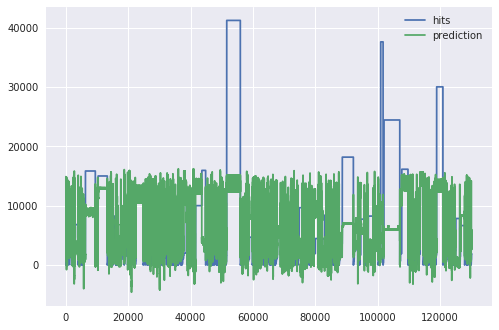

In [63]:
df_pd.plot()